# Lab 4

### <span style="color:chocolate"> Submission requirements </span>

Your homework will not be graded if your notebook doesn't include output. In other words, <span style="color:red"> make sure to rerun your notebook before submitting to Gradescope </span> (Note: if you are using Google Colab: go to Edit > Notebook Settings  and uncheck Omit code cell output when saving this notebook, otherwise the output is not printed).

Additional points may be deducted if these requirements are not met:
    
* Comment your code
* Each graph should have a title, labels for each axis, and (if needed) a legend. Each graph should be understandable on its own
* Try and minimize the use of the global namespace (meaning, keep things inside functions)
* Upload your .ipynb file to Gradescope when done
---

In this lab we will train classifiers for images using [logistic regression](https://en.wikipedia.org/wiki/Logistic_regression) and Tensorflow.

In [1]:
# Import the libraries we'll use below.
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns  # for nicer plots
sns.set(style="darkgrid")  # default style

import tensorflow as tf
from tensorflow import keras
from keras import metrics
tf.get_logger().setLevel('INFO')

/tmp/ipykernel_91130/4079152548.py:4: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
2024-02-11 16:36:33.133547: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-11 16:36:33.133574: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-11 16:36:33.134551: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable 

In [2]:
# Check that GPU is connected
tf.config.experimental.list_physical_devices('GPU')

2024-02-11 16:36:34.295253: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-11 16:36:34.328736: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-11 16:36:34.329076: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Understanding the data
We'll train models on the [Fashion MNIST](https://github.com/zalandoresearch/fashion-mnist) dataset. This consists of 70,000 grayscale images (28x28). Each image is associated with 1 of 10 classes. The dataset was split by the creators; there are 60,000 training images and 10,000 test images. 

Fashion MNIST classes:
* T-shirt/top
* Trouser
* Pullover
* Dress
* Coat
* Sandal
* Shirt
* Sneaker
* Bag
* Ankle boot

Before doing any training (or evaluating), let's make sure we understand what we're working with. 

### Load the data
Tensorflow includes a growing [library of datasets](https://www.tensorflow.org/datasets/catalog/overview) and makes it easy to load them in numpy arrays.

In [3]:
from keras.datasets import fashion_mnist

# Load the Fashion MNIST dataset.
(X_train, Y_train), (X_test, Y_test) = fashion_mnist.load_data()

# Flatten Y_train and Y_test, so they become vectors of label values.
# The label for X_train[0] is in Y_train[0].
Y_train = Y_train.flatten()
Y_test = Y_test.flatten()

### Basic Analysis
Notice that `X_train`, `Y_train`, `X_test`, and `Y_test` are all numpy arrays. Let's print their shapes to confirm.

In [4]:
print("X_train.shape:", X_train.shape)
print("Y_train.shape:", Y_train.shape)
print("X_test.shape:", X_test.shape)
print("Y_test.shape:", Y_test.shape)

X_train.shape: (60000, 28, 28)
Y_train.shape: (60000,)
X_test.shape: (10000, 28, 28)
Y_test.shape: (10000,)


Notice that there are 60,000 instances in `X_train`. Each of these is a grayscale image represented by an 28-by-28 array of grayscale pixel values between 0 and 255 (the larger the value, the lighter the pixel). Before we continue, let's apply linear scaling to our pixel values, so they all fall between 0 and 1.

In [5]:
# Pixel values range from 0 to 255. To normalize the data, 
# we just need to divide all values by 255.
X_train = X_train / 255
X_test = X_test / 255

In the previous lab, our input data had just a few features. Here, we treat **every pixel value as a separate feature**, so each input example has 28x28 (784) features!

Fashion MNIST images have one of 10 possible labels (shown above). Since the labels are indices 0-9, let's keep a list of (string) names for convenience.

In [6]:
label_names = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
               'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']

Next let's use the `imshow` function to look at the first few images in the training set.

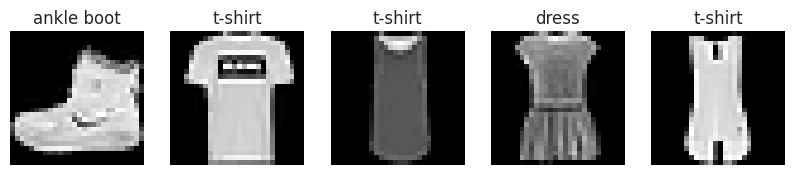

In [7]:
# Create a figure with subplots. This returns a list of object handles in axs
# which we can use to populate the plots.
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(10,5))
for i in range(5):
  image = X_train[i]
  label = Y_train[i]
  label_name = label_names[label]
  axs[i].imshow(image, cmap='gray')
  axs[i].set_title(label_name)
  axs[i].axis('off')
plt.show()

---
### Exercise 1 (8 points)

Display the first 5 images for each class in a 10x5 grid.

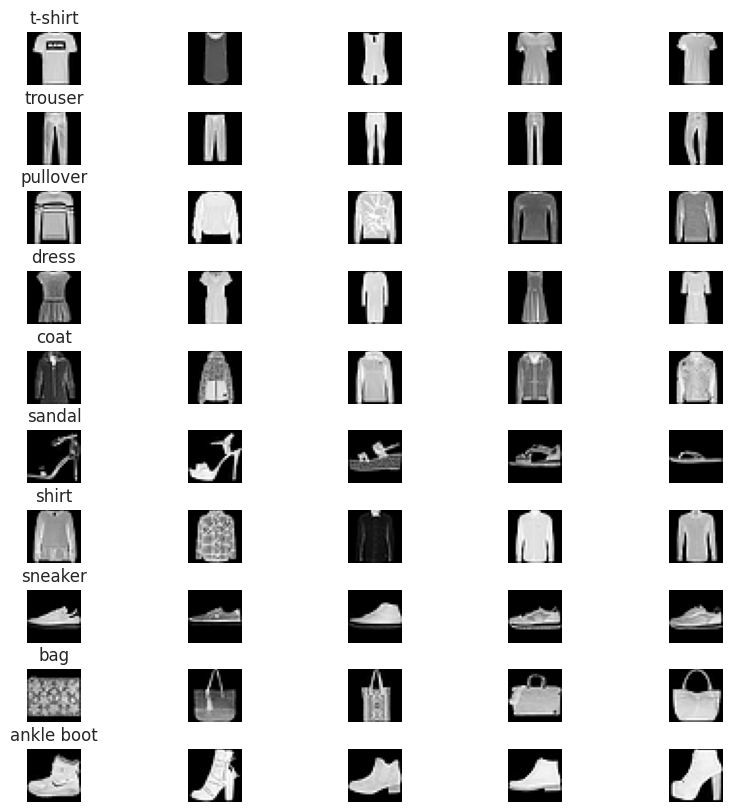

In [8]:
# YOUR CODE HERE
def one(X, Y, label_names):
    """
    Display the first five images from a feature set for each of the possible classes that
    label those features.

    args:
        X(3d numpy array): the features set containing grayscale images
        Y(1d numpy array): the classes of X
    
    returns:
        The first five images for each class in a i x 5 grid, where i is the number of unique
        classes.
    """
    unique_classes = np.unique(Y)
    fig, ax = plt.subplots(nrows=len(unique_classes), ncols=5, figsize=(10,len(unique_classes)))
    fig.subplots_adjust(hspace=0.5)
    for i, j in enumerate(unique_classes):
        label = label_names[j]
        images = np.where(Y == j)[0][:5]
        for k, l in enumerate(images):
            ax[i,k].imshow(X[l], cmap='gray')
            if k == 0:
                ax[i,k].set_title(label)
            ax[i,k].axis('off')

    plt.show()

one(X_train, Y_train, label_names)

---

## Sneaker Classification
There are many things we can do with this dataset. Following our lectures, let's start with binary classification. We'll train a sneaker classifier, using sneaker images (class 7) as our positive examples ($y=1$) and all other images as negative examples ($y=0$).

Once we've trained a model, it will produce predictions $\hat{y}$, the probability that an input image $x$ is a sneaker.

### Data Preprocessing
Before we continue, we need to prepare the data for our binary classification task. The label for all the sneaker images should be 1 and the label for all the non-sneaker images should be 0. 

Programming note: Numpy allows us to perform what is called [boolean array indexing](https://docs.scipy.org/doc/numpy/reference/arrays.indexing.html#boolean-array-indexing).
This means that a numpy array $A$ can be be modified according to boolean conditions in a matching sized array $B$ 
as follows: $A[B]$.
We use this indexing to efficiently set our binary labels below.

In [9]:
# Make copies of the original dataset for binary classification task.
X_train_binary = np.copy(X_train)
X_test_binary = np.copy(X_test)
Y_train_binary = np.copy(Y_train)
Y_test_binary = np.copy(Y_test)

# Set labels: 1 for sneaker images, 0 for the others.
# Note that a boolean array is created when Y_train_binary != 7 is evaluated.
Y_train_binary[Y_train_binary != 7] = 0.0 
Y_train_binary[Y_train_binary == 7] = 1.0
Y_test_binary[Y_test_binary != 7] = 0.0
Y_test_binary[Y_test_binary == 7] = 1.0

---
### Exercise 2 (8 points)


Before training any models, let's work some more with our raw feature values, comparing sneaker and non-sneaker images.

1. Find all sneaker images in `X_train_binary` and compute the mean and standard deviation of the center pixel across all sneaker images. The center pixel is located at position [14, 14].

2.   Find all non-sneaker images in `X_train_binary` and compute the mean and standard deviation of the center pixel  across all non-sneaker images. The center pixel is located at position [14, 14].

3. Repeat 1 and 2 for the pixel located at positon [3, 14].

4. Based on your results, do you think there is some evidence that suggests that we can use pixel values to discriminate between sneaker and non-sneaker images? Justify your answer.

In [10]:
# YOUR CODE HERE (1-3)
def two(X, Y, pixel_position, class_value):
    """
    Find the mean and standard deviation of a given pixel position in an array
    containing gray scale pixel for images that fit a certain class (Y == 1.0).

    args:
        X (3d numpy array): pixel data
        Y (1d numpy array): binary class identifier
        pixel_position (1d numpy array): list containing two values for the position
                                         of the pixel
        class_value = binary class value (0.0 or 1.0)

    returns:
        pixel_mean: the mean value of the given pixel position
        pixel_sd: the standard deviation of the given pixel position
    """
    
    sneaks = X[np.where(Y == class_value)]
    pixel_mean = np.mean(sneaks[:,pixel_position[0],pixel_position[1]])
    pixel_sd = np.std(sneaks[:,pixel_position[0],pixel_position[1]])

    return pixel_mean, pixel_sd

one_one = two(X_train_binary, Y_train_binary, np.array([14,14]), 1.0)
one_two = two(X_train_binary, Y_train_binary, np.array([14,14]), 0.0)
one_three = two(X_train_binary, Y_train_binary, np.array([3,14]), 1.0)
one_four = two(X_train_binary, Y_train_binary, np.array([3,14]), 0.0)
print("Mean of Pixel at [14, 14] for Sneakers:", one_one[0])
print("Standard Deviation of Pixel at [14, 14] for Sneakers:", one_one[1])
print("Mean of Pixel at [14, 14] for non-Sneakers:", one_two[0])
print("Standard Deviation of Pixel at [14, 14] for non-Sneakers:", one_two[1])
print("Mean of Pixel at [3, 14] for Sneakers:", one_three[0])
print("Standard Deviation of Pixel at [3, 14] for Sneakers:", one_three[1])
print("Mean of Pixel at [3, 14] for non-Sneakers:", one_four[0])
print("Standard Deviation of Pixel at [3, 14] for non-Sneakers:", one_four[1])

Mean of Pixel at [14, 14] for Sneakers: 0.6279993464052288
Standard Deviation of Pixel at [14, 14] for Sneakers: 0.2420192071490903
Mean of Pixel at [14, 14] for non-Sneakers: 0.5365848220769789
Standard Deviation of Pixel at [14, 14] for non-Sneakers: 0.31489747339469804
Mean of Pixel at [3, 14] for Sneakers: 0.001250326797385621
Standard Deviation of Pixel at [3, 14] for Sneakers: 0.02829347092206015
Mean of Pixel at [3, 14] for non-Sneakers: 0.46437283950617286
Standard Deviation of Pixel at [3, 14] for non-Sneakers: 0.3678363831207802


*Written answer:*

1. Mean = $0.628$, Standard Deviation = $0.242$

2. Mean = $0.537$, Standard Deviation = $0.315$

3. Sneakers: Mean = $0.001$, Standard Deviation = $0.028$
   Non-Sneakers: Mean = $0.464$, Standard Deviation = $0.368$

4. I think that there is evidence that pixel values could be used to determine whether or not an image is a sneaker. This is because the the difference in means of pixel values for sneaker and non-sneaker images is high, particularly for the pixel located at [3, 14] in this example.

---

### Data Shuffling
Just like in the previous lab, we'll be using SGD (Stochastic Gradient Descent) for training. This means that it is important that **each batch is a random sample of the data**.

This time we can use [integer array indexing](https://numpy.org/doc/stable/reference/arrays.indexing.html#integer-array-indexing) to re-order the data and labels using a list of shuffled indices.

In [11]:
np.random.seed(0) # For reproducibility

indices = np.arange(X_train_binary.shape[0])
shuffled_indices = np.random.permutation(indices)

# Re-order training examples and corresponding labels using the randomly
# shuffled indices.
X_train_binary = X_train_binary[shuffled_indices]
Y_train_binary = Y_train_binary[shuffled_indices]

## Logistic Regression

Recall that logistic regression is an application of the logistic (sigmoid) function to the linear regression model:

\begin{equation}
y=\frac{1}{1+e^{-z}} 
\end{equation}

<center>
<img src="https://developers.google.com/machine-learning/crash-course/images/SigmoidFunction.png" alt="Sigmoid Function" width="45%"/>
</center>

where:

\begin{equation}
z = b + w_1x_1 + w_2x_2 + ... + w_nx_n
\end{equation}

As you can see, the output $y$ is in the range $[0,1]$, the probability of the positive class. If we want a label (instead of a probability), we need to choose a threshold, like $0.5$. A value above or equal to that threshold indicates that the input should be classified as positive (e.g., sneaker); a value below the threshold indicates that the input should be classified as negative (e.g. non-sneaker).

### Loss Function

In place of MSE, which we used for linear regression, we need a loss function for logistic regression that's appropriate for classification. The *Log Loss* (also known as *binary cross-entropy*), is defined as follows:

\begin{equation}
-\frac{1}{|Y|} \sum_{y_i \in Y}y_i log(\hat{y}_i) + (1−y_i)log(1−\hat{y}_i)
\end{equation}

Recall that $y_i$ is the label for example $i$ and $\hat{y_i}$ is the predicted probability (of the positive class) for example $i$. Note that only the first term in the sum is active for positive examples (the second term is 0 when $y_i = 1$) and only the second term in the sum is active for negative examples (the first term is 0 when $y_i = 0$).

The log loss is differentiable, allowing us to compute gradients and run SGD. It also happens to be convex, which guarantees that SGD (with a suitable learning rate) will produce a global minimum.

## Baseline

When dealing with classification problems, a simple, but useful baseline is to select the *majority* class (the most common label in the training set) and use it as the prediction for all inputs.

Our training dataset consists of 6,000 sneaker examples (10%), and 54,000 non-sneaker images (90%). So our majority class baseline classifies everything as *non-sneaker*. Notice that, for our particular dataset, this will yield an accuracy of 90%. Let's see if we can train a model that can beat the baseline.

In [12]:
print("Number of sneaker images in training set: %d"%(Y_train_binary == 1).sum())
print("Number of non-sneaker images in training set: %d"%(Y_train_binary == 0).sum())

Number of sneaker images in training set: 6000
Number of non-sneaker images in training set: 54000


---
### Exercise 3 (8 points)

Implement a function that computes the Log Loss (binary cross-entropy) metric and use it to evaluate our baseline on both the train and test data. Use 0.1 as the predicted probability for your baseline (reflecting what we know about the original distribution of classes in our dataset).

In [13]:
def log_loss(Y_true, Y_pred, m):
  """Returns the binary log loss for a list of labels and predictions.
  
  Args:
    Y_true: A list of (true) labels (0 or 1)
    Y_pred: A list of corresponding predicted probabilities
    m: the cardinality of Y_true

  Returns:
    Binary log loss
  """
  epsilon = 1e-15
  np.clip(Y_pred, epsilon, 1 - epsilon)

  return np.sum((Y_true * np.log(Y_pred)) + ((1 - Y_true) * np.log(1 - Y_pred))) * -(1/m)

def three(Y_true, baseline):
  """
  Using the helper function log_loss(Y_true, Y_pred, m), compare the loss of a given set of labels
  compared to a given baseline value.

  Args:
    Y_true (numpy array): the set of labels
    baseline (float): the baseline value

  Returns:
    loss: The log loss
  """
  m = len(Y_true)
  baseline = np.full(m, baseline)
  loss = log_loss(Y_true, baseline, m)
  
  return loss

print("Training set:", three(Y_train_binary, 0.1))
print("Test set:", three(Y_test_binary, 0.1))

Training set: 0.3250829733914482
Test set: 0.3250829733914482


---

## Build a model
We will use Tensorflow/Keras to build our logistic regression model. This should look very similar to the models you built for linear regression but with a few key differences:
* We use the Keras flatten layer to turn the 2-D 28x28 pixel grid inputs into 1-D vector inputs.
* We configure our dense layer with a sigmoid activation, which applies a sigmoid function to the output of the linear mapping $xW^T$.
* We specify binary_crossentropy as the loss (synonymous with log loss) when compiling the model.

In [14]:
def build_model(learning_rate=0.01):
  """Build a TF logistic regression model using Keras.

  Args:
    learning_rate: The desired learning rate for SGD.

  Returns:
    model: A tf.keras model (graph).
  """
  # This is not strictly necessary, but each time you build a model, TF adds
  # new nodes (rather than overwriting), so the colab session can end up
  # storing lots of copies of the graph when you only care about the most
  # recent. Also, as there is some randomness built into training with SGD,
  # setting a random seed ensures that results are the same on each identical
  # training run.
  tf.keras.backend.clear_session()
  np.random.seed(0)
  tf.random.set_seed(0)

  # Build a model using keras.Sequential.
  model = keras.Sequential()

  # Keras layers can do pre-processing. This layer will take our 28x28 images
  # and flatten them into vectors of size 784.
  model.add(keras.layers.Flatten())
  
  # This layer constructs the linear set of parameters for each input feature
  # (as well as a bias), and applies a sigmoid to the result. The result is
  # binary logistic regression.
  model.add(keras.layers.Dense(
      units=1,                     # output dim (for binary classification)
      use_bias=True,               # use a bias param
      activation="sigmoid"         # apply the sigmoid function!
  ))

  # Use the SGD optimizer as usual.
  optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)

  # We specify the binary_crossentropy loss (equivalent to log loss).
  # Notice that we are including 'binary accuracy' as one of the metrics that we
  # ask Tensorflow to report when evaluating the model.
  model.compile(loss='binary_crossentropy', 
                optimizer=optimizer, 
                metrics=[metrics.binary_accuracy])

  return model

Let's make sure model building code works. Before training, the parameters of the model are initialized randomly (this is the default). While the untrained model won't make good predictions, we should still be able to pass data through it and get probability outputs.

In [15]:
# Build the model.
model = build_model()

# Make a prediction for five inputs.
print(model.predict(X_train_binary[0:5]))

1/1 [==============================] - 0s 139ms/step
[[0.24838361]
 [0.32388276]
 [0.26133937]
 [0.39288998]
 [0.28673384]]


2024-02-11 16:36:36.966669: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-11 16:36:36.966870: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-11 16:36:36.967176: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

As expected, the outputs look like probabilities (in [0,1]). Once the model is trained, we hope that these predictions correspond to the probability that each input image is a sneaker.

## Train a model
Let's train the model. Note that we're using 10% of the training data as a *validation split*. This serves a similar purpose to our test data, allowing us to check for over-fitting during training. We don't use the test data here because we might run lots of experiments, and over time, we might adjust settings to improve results on the validation set. We want to preserve the purity of the test data to allow for the cleanest possible evaluation at the end of the experimentation process.

In [16]:
model = build_model(learning_rate=0.01)

# Fit the model.
history = model.fit(
  x = X_train_binary,   # our binary training examples
  y = Y_train_binary,   # corresponding binary labels
  epochs=5,             # number of passes through the training data
  batch_size=64,        # mini-batch size for SGD
  validation_split=0.1, # use a fraction of the examples for validation
  verbose=1             # display some progress output during training
  )

# Convert the return value into a DataFrame so we can see the train loss 
# and binary accuracy after every epoch.
history = pd.DataFrame(history.history)
display(history)

Epoch 1/5


 65/844 [=>............................] - ETA: 1s - loss: 0.2634 - binary_accuracy: 0.8957 

2024-02-11 16:36:38.243220: I external/local_xla/xla/service/service.cc:168] XLA service 0x7e9b50d66ef0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-02-11 16:36:38.243239: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3080, Compute Capability 8.6
2024-02-11 16:36:38.250732: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
I0000 00:00:1707687398.290228   91450 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


844/844 [==============================] - 2s 2ms/step - loss: 0.1465 - binary_accuracy: 0.9371 - val_loss: 0.1166 - val_binary_accuracy: 0.9460
Epoch 2/5
844/844 [==============================] - 2s 2ms/step - loss: 0.1079 - binary_accuracy: 0.9548 - val_loss: 0.1036 - val_binary_accuracy: 0.9557
Epoch 3/5
844/844 [==============================] - 1s 2ms/step - loss: 0.0970 - binary_accuracy: 0.9623 - val_loss: 0.0962 - val_binary_accuracy: 0.9602
Epoch 4/5
844/844 [==============================] - 1s 2ms/step - loss: 0.0901 - binary_accuracy: 0.9664 - val_loss: 0.0909 - val_binary_accuracy: 0.9628
Epoch 5/5
844/844 [==============================] - 2s 2ms/step - loss: 0.0853 - binary_accuracy: 0.9685 - val_loss: 0.0877 - val_binary_accuracy: 0.9642


,loss,binary_accuracy,val_loss,val_binary_accuracy
0,0.146524,0.937111,0.116622,0.946000
1,0.107938,0.954833,0.103649,0.955667
2,0.096959,0.962315,0.096184,0.960167
3,0.090113,0.966407,0.090940,0.962833
4,0.085269,0.968463,0.087696,0.964167


## Evaluate the model

Good news. It appears that our model is doing better than our baseline. Let's use the trained model to predict probabilities for the test data. We can use `predict` to run *inference*.

In [17]:
# The result of model.predict has an extra dimension, so we flatten to get a
# vector of predictions. Note that these are the predicted probabilities of the
# positive (sneaker) class.
test_predictions = model.predict(X_test_binary).flatten()
print(test_predictions.shape)
print(test_predictions)

  1/313 [..............................] - ETA: 7s

313/313 [==============================] - 0s 553us/step
(10000,)
[3.0095300e-01 2.0957252e-07 7.9686474e-04 ... 9.3471090e-04 3.9052165e-03
 3.5600877e-01]


---
### Exercise 4 (8 points)

Compute the accuracy on the test data using a threshold of 0.5. Remember to use Y_test_binary for the true labels.

In [18]:
# YOUR CODE HERE
def four(Y_pred_prob, Y_true, threshold=0.5):
    """
    Compute an accuracy score for a given vector of binary prediction probabilities and
    a vector of true labels.

    Args:
        Y_pred_prob (numpy array): the vector of binary prediction probabilities
        Y_true: the vector of true labels

    Returns:
        An accuracy score 
    """

    Y_pred = Y_pred_prob.copy()
    Y_pred[Y_pred < threshold] = 0
    Y_pred[Y_pred >= threshold] = 1

    correct = np.sum(Y_pred == Y_true)

    accuracy = correct / Y_true.size

    return accuracy

print("Accuracy:", four(test_predictions, Y_test_binary)) 

Accuracy: 0.9699


---

## Analyze the model

Let's investigate what the model has learned. Recall how to get the learned weights from the model:

In [19]:
# The model includes 2 layers: a flattening layer and a dense layer.
print(model.layers)

# Retrieve the weights and biases from the dense layer.
weights, biases = model.layers[1].get_weights()
bias = biases[0]  # there's only 1 bias
weights = weights.flatten()  # flatten the weights to a vector
print('Bias:', bias)
print('Weights shape:', weights.shape)

[<keras.src.layers.reshaping.flatten.Flatten object at 0x7e9ca03edf50>, <keras.src.layers.core.dense.Dense object at 0x7e9ca060e150>]
Bias: -0.4514803
Weights shape: (784,)


---
### Exercise 5 (8 points)

1. Using just the bias calculated in the model, compute the predicted probability (of the sneaker class) for an image of all 0-valued inputs.

2. Construct a fake image with all 0s and use model.predict.

3. Confirm if they agree

In [20]:
# YOUR CODE HERE

def five(sample, model):
    """
    Return the default prediction of a binary classifer model using only its bias.
    Then return the prediciton using a sample where every weight is 0 to confirm it.

    Args:
        sample (numpy array): a sample with all 0 value weights
        model: a binary classifer model based on logistic regression

    Returns:
        default_bias: the default prediction using only the model's bias
        default_predict: the default prediction returned by an actual sample with 0
        value weights
    """

    biases = model.layers[1].bias.numpy()
    bias = biases[0]
    default_bias = 1 / (1 + np.exp(-bias))

    sample = sample.reshape(1, 28, 28)
    default_predict = model.predict(sample).flatten()[0]

    return round(default_bias, 7), round(default_predict, 7)

sample = np.zeros((28,28))
defaults = five(sample, model)
print("Default Prediction Using Bias:", defaults[0])
print("Default Prediction Using Sample of 0s:", defaults[1])
if defaults[0] - defaults[1] < 0.0000001:
    print("They [essentially] agree!")
else:
    print("They don't agree...")

1/1 [==============================] - 0s 10ms/step
Default Prediction Using Bias: 0.3890089
Default Prediction Using Sample of 0s: 0.3890089
They [essentially] agree!


---